# Car Price Regression - Brandon Nguyen

## Table of contents

- [1. Problem Statement](#1-problem-statement)
- [2. Data Overview & Initial Checks](#2-data-overview--initial-checks)
- [3. Data Preprocessing](#3-data-preprocessing)
- [4. Exploratory Data Analysis (EDA)](#4-exploratory-data-analysis-eda)
- [5. Model Training & Evaluation](#5-model-training--evaluation)
- [6. Model Comparison & Selection](#6-model-comparison--selection)
- [7. Predict Test Data & Saving Results](#7-predict-test-data--saving-results)
- [8. Model Performance Assessment](#8-model-performance-assesment)


## 1. Problem Statement

**Objective**:
- To develop a supervised machine learning model that accurately predicts car prices based on a diverse set of vehicle features.

**Description**:
- This project utilizes a comprehensive dataset containing various attributes of cars, including brand, model, year, transmission, mileage, fuel type, tax, mpg, engine size, and more. The target variable is price, while all other features serve as predictors.

- The goal is to build a regression model that can generalize well to unseen data and provide precise price estimates. Various techniques such as feature engineering, model evaluation, cross-validation, and hyperparameter tuning are employed to improve predictive performance.

## 2. Data Overview & Initial Checks

- Check missing values
- Check data type
- Check Duplicates
- Check various categories present in different categorical columns

In [36]:
# LOADING DATA WITH NORMALIZATION


import pandas as pd
import numpy as np
import os

root = "."
subfolders = ['test_features', 'train_dir']



all_data = {}

for subfolder in subfolders:
    folder_path = os.path.join(root, subfolder)
    dataset_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df_name = filename.replace(".csv", "")
            df = pd.read_csv(file_path)

            # Normalize column names
            df.columns = df.columns.str.lower().str.strip()

            # Normalize all string fields: lowercase + remove all spaces
            for col in df.select_dtypes(include=['object']).columns:
                df[col] = df[col].astype(str).str.lower().str.replace(" ", "", regex=False)

            dataset_dict[df_name] = df
            print(f"Loaded and normalized {filename} from {subfolder}")
    all_data[subfolder] = dataset_dict


Loaded and normalized test_features.csv from test_features
Loaded and normalized audi.csv from train_dir
Loaded and normalized bmw.csv from train_dir
Loaded and normalized cclass.csv from train_dir
Loaded and normalized focus.csv from train_dir
Loaded and normalized ford.csv from train_dir
Loaded and normalized hyundi.csv from train_dir
Loaded and normalized merc.csv from train_dir
Loaded and normalized skoda.csv from train_dir
Loaded and normalized toyota.csv from train_dir
Loaded and normalized vauxhall.csv from train_dir
Loaded and normalized vw.csv from train_dir


In [37]:
# CHECKING FOR MISSING VALUES

for subfolder, datasets in all_data.items():
    for df_name, df in datasets.items():
        null_counts = df.isnull().sum()
        null_cols = null_counts[null_counts > 0]
        if not null_cols.empty:
            null_percent = (null_cols / len(df)) * 100
            print(f"Dataset: {df_name}.csv in '{subfolder}' folder has missing values:")
            for col in null_cols.index:
                print(f"  - {col}: {null_cols[col]} missing ({null_percent[col]:.2f}%)")
            print()


Dataset: test_features.csv in 'test_features' folder has missing values:
  - mpg: 1871 missing (8.62%)
  - enginesize: 1871 missing (8.62%)



In [38]:
## CHECK DATA COLUMNS STRUCTURE

from collections import Counter

# Store column sets for each dataset
column_sets = {}

for subfolder, datasets in all_data.items():
    for df_name, df in datasets.items():
        column_sets[f"{subfolder}/{df_name}"] = set(df.columns)

all_columns = list(column_sets.values())
most_common_columns = Counter(map(frozenset, all_columns)).most_common(1)[0][0]

for name, cols in column_sets.items():
    missing = most_common_columns - cols
    extra = cols - most_common_columns
    if missing or extra:
        print(f"\n{name}.csv has structural differences:")
        if missing:
            print(f"  - Missing columns: {sorted(missing)}")
        if extra:
            print(f"  - Extra/unexpected columns: {sorted(extra)}")



test_features/test_features.csv has structural differences:
  - Missing columns: ['price']
  - Extra/unexpected columns: ['brand', 'predict_price']

train_dir/cclass.csv has structural differences:
  - Missing columns: ['mpg', 'tax']

train_dir/focus.csv has structural differences:
  - Missing columns: ['mpg', 'tax']

train_dir/hyundi.csv has structural differences:
  - Missing columns: ['tax']
  - Extra/unexpected columns: ['tax(£)']


In [39]:
# Find columns common to all datasets
all_column_sets = []

for subfolder, datasets in all_data.items():
    for df_name, df in datasets.items():
        all_column_sets.append(set(df.columns))

common_columns = set.intersection(*all_column_sets)

print("Columns common to all datasets:")
for col in sorted(common_columns):
    print(f" - {col}")


Columns common to all datasets:
 - enginesize
 - fueltype
 - mileage
 - model
 - transmission
 - unnamed: 0
 - year


In [40]:
# CHECKING FOR DUPLICATES

# Check rows where any two non-numeric columns have the same value in a row
# Normalize string values and check if model == brand
for subfolder, datasets in all_data.items():
    for df_name, df in datasets.items():
        if 'model' in df.columns and 'brand' in df.columns:
            model_norm = df['model'].astype(str).str.lower().str.strip()
            brand_norm = df['brand'].astype(str).str.lower().str.strip()

            mask = model_norm == brand_norm
            count = mask.sum()

            if count > 0:
                print(f"\nDataset '{df_name}.csv' in '{subfolder}' has {count} rows where model == brand (after normalization):")
                print(df.loc[mask, ['model', 'brand']].drop_duplicates().head(5))






Dataset 'test_features.csv' in 'test_features' has 1871 rows where model == brand (after normalization):
        model   brand
4861   cclass  cclass
16056   focus   focus


### Conclusion 

- The dataset in **training_dir** has the most common set of columns, which are: enginesize, fueltype, mileage, model, transmission, year and price. 
- The dataset in **training_dir** does not have **brand** column --> data file name indicates the brand --> use it to add to column brand (except cclass and focus). cclass belongs to merc, focus belongs to ford
- Fill mising data on column **'mpg', 'tax'** of **cclass** and **focus**
- Convert value in **'tax(£)'** to tax (using convertion rate GBP --> USD), change the column name to match also

- In the **test_features** dataset, there are 1,871 rows where the **brand** values are duplicated as both cclass and focus, which appear to be incorrect. The corresponding brand values need to be reviewed and adjusted before use to predict.

## 3. Data Preprocessing

In [41]:
# INSERTING BRAND NAME

for filename, df in all_data['train_dir'].items():
    # Drop first column (assumed to be just an index)
    df.drop(df.columns[0], axis=1, inplace=True)

    brand_name = filename  
    df.insert(0, 'brand', brand_name)

# Manual overrides for merged brands (cclass belongs to merc, focus belongs to ford)
brand_corrections = {
    'cclass': 'merc',
    'focus': 'ford'
}

for filename, new_brand in brand_corrections.items():
    if filename in all_data['train_dir']:
        all_data['train_dir'][filename]['brand'] = new_brand


train_df = pd.concat(all_data['train_dir'].values(), ignore_index=True)
test_df = pd.concat(all_data['test_features'].values(), ignore_index=True)

print("Brand distribution in train_dir:")
print(train_df['brand'].value_counts())

Brand distribution in train_dir:
brand
ford        18735
merc        13614
vw          12125
vauxhall    10905
bmw          8624
audi         8534
toyota       5390
skoda        5013
hyundi       3888
Name: count, dtype: int64


In [42]:
## FILL MISSING VALUES (tax and mpg) 

# For train_df : convert tax(£) to tax in USD, drop tax(£) column, fill missing values of mpg with mean value of same categories

gbp_to_usd = 1.33

# Print missing counts before filling
print(" Before filling missing values:")
print(f"Missing tax: {train_df['tax'].isna().sum()}")
print(f"Missing mpg: {train_df['mpg'].isna().sum()}")

# Convert tax(£) to USD only where tax is NaN
condition = train_df['tax'].isna() & train_df['tax(£)'].notna()
train_df.loc[condition, 'tax'] = train_df.loc[condition, 'tax(£)'] * gbp_to_usd

# Fill missing using brand + model + year
group_cols = ['brand', 'model', 'year']
tax_means = train_df.groupby(group_cols)['tax'].transform('mean')
mpg_means = train_df.groupby(group_cols)['mpg'].transform('mean')

train_df['tax'] = train_df['tax'].fillna(tax_means)
train_df['mpg'] = train_df['mpg'].fillna(mpg_means)

# If still missing, use brand + model
group_cols_2 = ['brand', 'model']
tax_means_2 = train_df.groupby(group_cols_2)['tax'].transform('mean')
mpg_means_2 = train_df.groupby(group_cols_2)['mpg'].transform('mean')

train_df['tax'] = train_df['tax'].fillna(tax_means_2)
train_df['mpg'] = train_df['mpg'].fillna(mpg_means_2)

# Drop tax(£)
train_df.drop(columns=['tax(£)'], inplace=True)

# Print missing counts after filling
print("\n After filling missing values:")
print(f"Missing tax: {train_df['tax'].isna().sum()}")
print(f"Missing mpg: {train_df['mpg'].isna().sum()}")





 Before filling missing values:
Missing tax: 11370
Missing mpg: 7482

 After filling missing values:
Missing tax: 0
Missing mpg: 0


In [43]:
# Branch Correction on testing data

brand_corrections = {
    'cclass': 'merc',
    'focus': 'ford'
}

correction_counts = {}

# Identify and correct rows where brand == model
for wrong_brand, correct_brand in brand_corrections.items():
    mask = (test_df['brand'] == test_df['model']) & (test_df['brand'] == wrong_brand)
    count = mask.sum()
    if count > 0:
        test_df.loc[mask, 'brand'] = correct_brand
        correction_counts[wrong_brand] = count

# Summary
print("\n Brand corrections applied based on matching model values:")
for wrong, count in correction_counts.items():
    print(f" - '{wrong}' → '{brand_corrections[wrong]}' ({count} rows fixed)")



 Brand corrections applied based on matching model values:
 - 'cclass' → 'merc' (780 rows fixed)
 - 'focus' → 'ford' (1091 rows fixed)


In [44]:

# FILL MISSING VALUES (tax and mpg) 

# For test_df :  fill missing values of mpg, enginesize with mean value of same categories

print("Before filling missing values in test_df:")
print(f"Missing mpg: {test_df['mpg'].isna().sum()}")
print(f"Missing enginesize: {test_df['enginesize'].isna().sum()}")

# Step 1: Fill using group mean by brand + model + year
group_cols = ['brand', 'model', 'year']
mpg_means = test_df.groupby(group_cols)['mpg'].transform('mean')
engine_means = test_df.groupby(group_cols)['enginesize'].transform('mean')

test_df['mpg'] = test_df['mpg'].fillna(mpg_means)
test_df['enginesize'] = test_df['enginesize'].fillna(engine_means)

# Step 2: Fill remaining using brand + model only
group_cols_2 = ['brand', 'model']
mpg_means_2 = test_df.groupby(group_cols_2)['mpg'].transform('mean')
engine_means_2 = test_df.groupby(group_cols_2)['enginesize'].transform('mean')

test_df['mpg'] = test_df['mpg'].fillna(mpg_means_2)
test_df['enginesize'] = test_df['enginesize'].fillna(engine_means_2)

# Show missing values after
print("\nAfter filling missing values in test_df:")
print(f"Missing mpg: {test_df['mpg'].isna().sum()}")
print(f"Missing enginesize: {test_df['enginesize'].isna().sum()}")


Before filling missing values in test_df:
Missing mpg: 1871
Missing enginesize: 1871

After filling missing values in test_df:
Missing mpg: 0
Missing enginesize: 0


In [45]:
# Check any remaining missing values of testing data

print(test_df.isna().sum())

unnamed: 0       0
model            0
year             0
transmission     0
mileage          0
fueltype         0
tax              0
mpg              0
enginesize       0
brand            0
predict_price    0
dtype: int64


In [46]:
# Save the cleaned and processed datasets to CSV files for using later, folder Cleaned_Data

import os

# Ensure the folder exists
output_folder = "Cleaned_Data"
os.makedirs(output_folder, exist_ok=True)

# Save the CSV files to the folder
train_df.to_csv(os.path.join(output_folder, "train_data.csv"), index=False)
test_df.to_csv(os.path.join(output_folder, "test_data.csv"), index=False)


## 4. Exploratory Data Analysis (EDA)

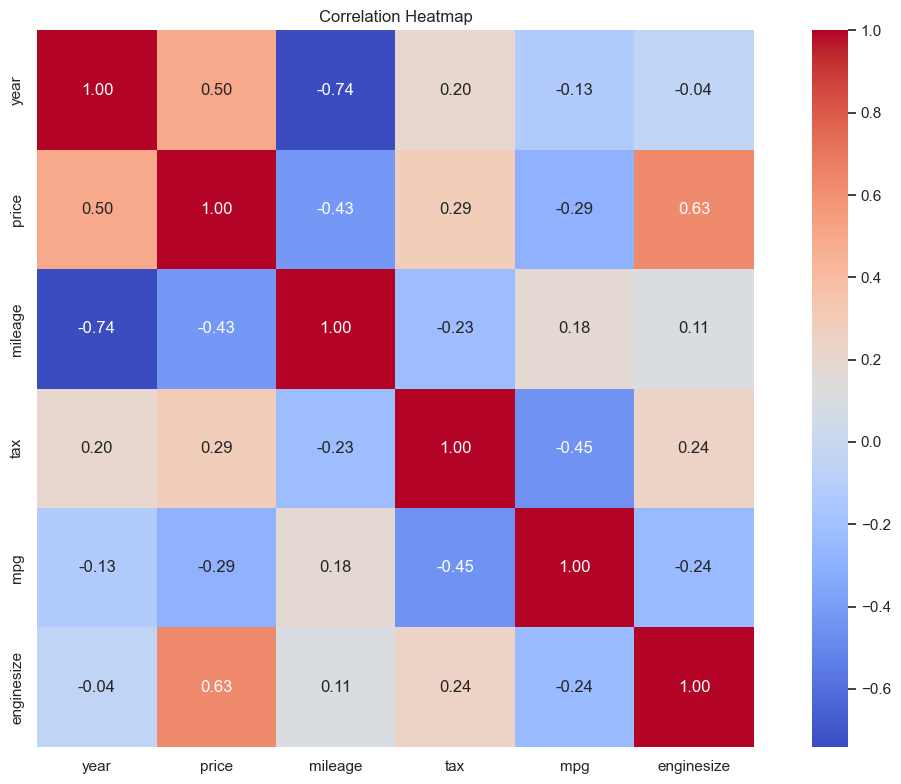

In [47]:
# CORRELATION ANALYSIS - HEAT MAP

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the plot folder exists
plot_folder = "submission_plots"
os.makedirs(plot_folder, exist_ok=True)

%matplotlib inline
sns.set(style="whitegrid", context="notebook")

# Choose only numerical columns for correlation analysis
numeric_cols = train_df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 8))
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(plot_folder,"correlation_heatmap.png"))
plt.show()


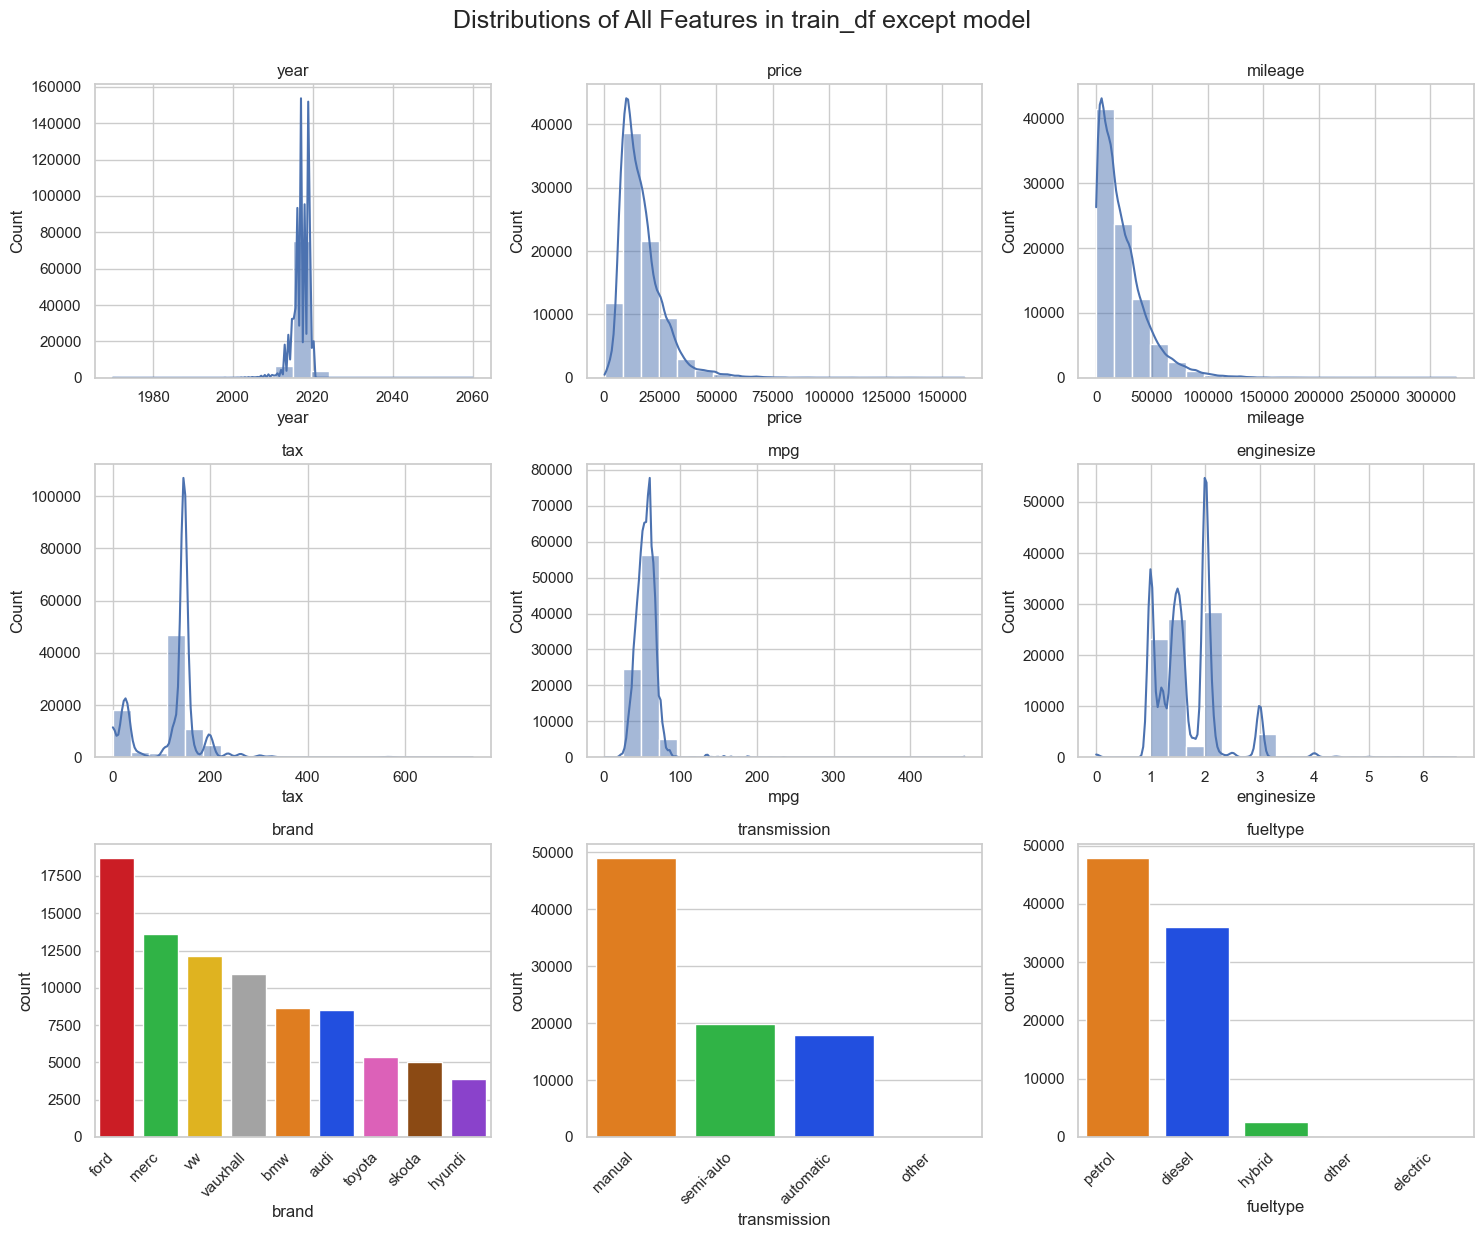

In [48]:
# Distribution of All Features except model - HISTOGRAMS

import matplotlib.pyplot as plt
import seaborn as sns

# Separate numeric and categorical columns
excluded_col = 'model'
numeric_cols = train_df.select_dtypes(include=['number']).columns.tolist()
cat_cols = train_df.select_dtypes(include=['object', 'category']).drop(columns=[excluded_col], errors='ignore').columns.tolist()


# Combine both types into a single list, and store their type for plotting
all_cols = [(col, 'num') for col in numeric_cols] + [(col, 'cat') for col in cat_cols]

# Set plot layout
n_cols = 3
n_rows = (len(all_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Loop through all columns
for i, (col, col_type) in enumerate(all_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    
    if col_type == 'num':
        sns.histplot(train_df[col], bins=20, kde=True)
    else:
        sns.countplot(data=train_df, x=col, palette="bright", hue=col, order=train_df[col].value_counts().index)
        plt.xticks(rotation=45, ha='right')
    
    plt.title(f"{col}")

plt.tight_layout()
plt.suptitle("Distributions of All Features in train_df except model", fontsize=18, y=1.03)
plt.savefig(os.path.join(plot_folder,"distributions_all_features.png"))
plt.show()

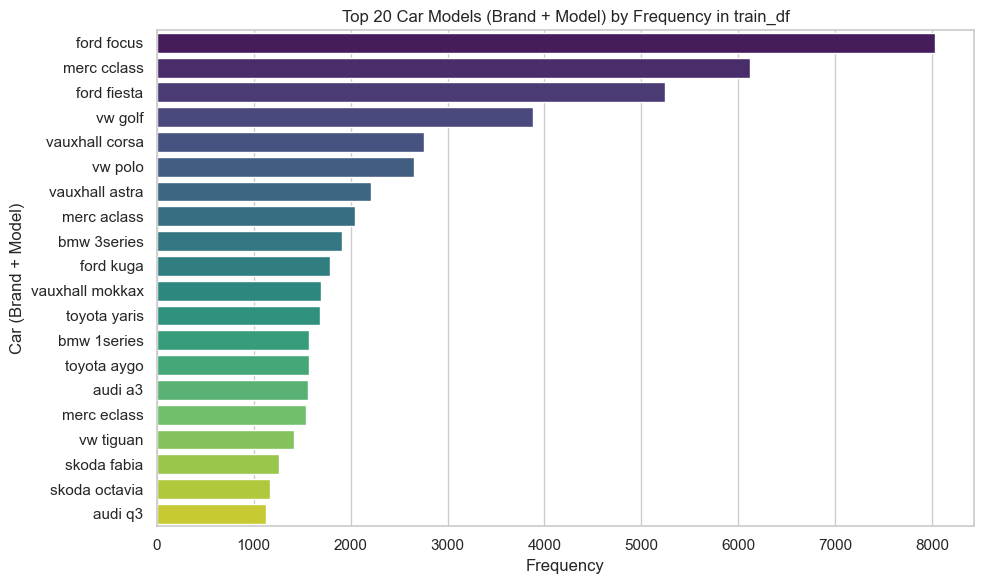

In [49]:
# TOP 20 car model

train_df['car_fullname'] = train_df['brand'] + " " + train_df['model']

n = 20
top_cars = train_df['car_fullname'].value_counts().head(n).reset_index()
top_cars.columns = ['car_fullname', 'count']

# Plot with hue and legend disabled
plt.figure(figsize=(10, 6))
sns.barplot(data=top_cars, x='count', y='car_fullname', hue='car_fullname', palette='viridis', legend=False)
plt.title(f'Top {n} Car Models (Brand + Model) by Frequency in train_df')
plt.xlabel('Frequency')
plt.ylabel('Car (Brand + Model)')
plt.tight_layout()
plt.savefig("submission_plots/top_20_cars.png")
plt.savefig(os.path.join(plot_folder,"distributions_all_features.png"))

plt.show()



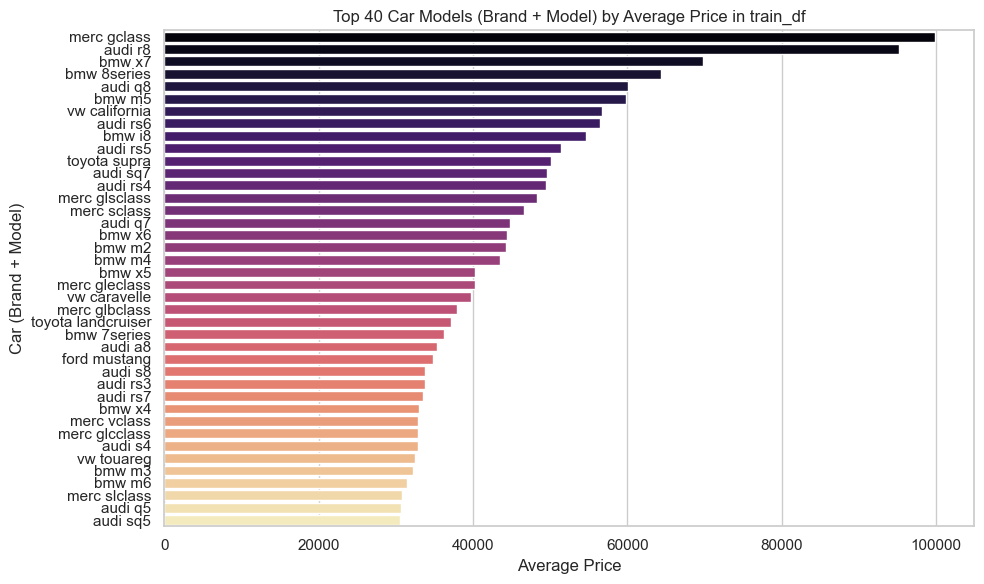

In [50]:
# TOP 40 car model by average price

# Calculate average price for each car_fullname
avg_prices_by_car = train_df.groupby('car_fullname')['price'].mean().sort_values(ascending=False)

n = 40
top_car_models = avg_prices_by_car.head(n).reset_index()
top_car_models.columns = ['car_fullname', 'avg_price']

# Plot (with hue to avoid seaborn warning)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_car_models, x='avg_price', y='car_fullname', hue='car_fullname', palette='magma', legend=False)
plt.title(f'Top {n} Car Models (Brand + Model) by Average Price in train_df')
plt.xlabel('Average Price')
plt.ylabel('Car (Brand + Model)')
plt.tight_layout()
plt.savefig(os.path.join(plot_folder,"top_40_cars_avg_price.png"))
plt.show()



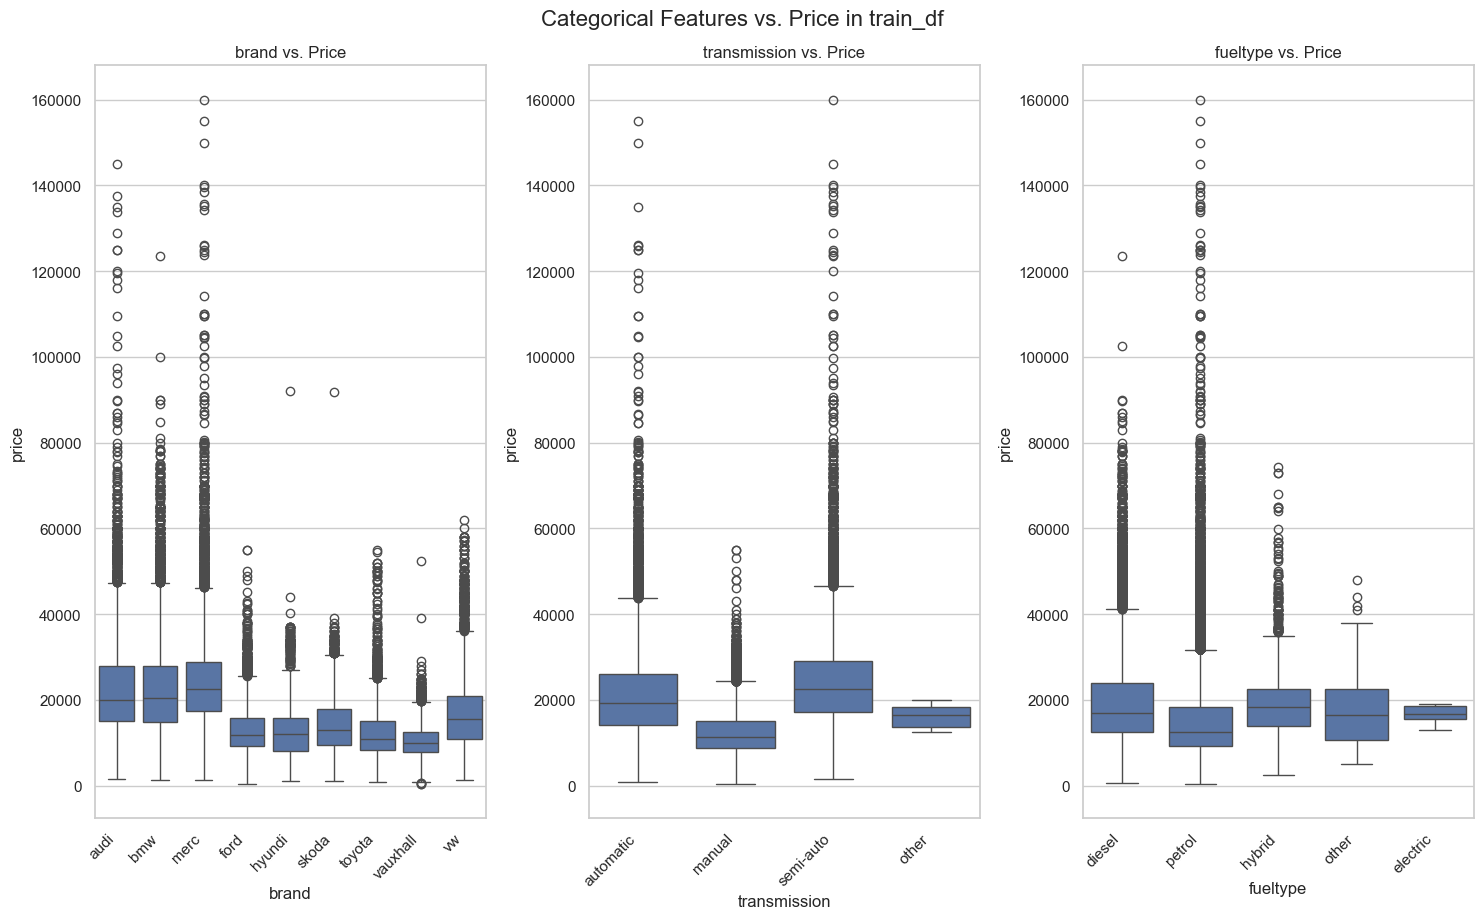

In [51]:
# Box plot Categorical Feature vs. Price

categorical_columns = ['brand', 'transmission', 'fueltype']

plt.figure(figsize=(15, len(categorical_columns) * 3))

for i, feature in enumerate(categorical_columns):
    plt.subplot((len(categorical_columns) + 2) // 3, 3, i + 1)
    sns.boxplot(data=train_df, x=feature, y='price')
    plt.title(f'{feature} vs. Price')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.suptitle("Categorical Features vs. Price in train_df", fontsize=16, y=1.02)
plt.savefig(os.path.join(plot_folder,"categorical_features_vs_price.png"))
plt.show()



**Observation**

- Brands like audi, bmw, and merc have many data points above the upper whisker. Several points go far beyond typical ranges, up to 160,000+, which is very high.
- All types show outliers, especially automatic and semi-auto, where the price spikes frequently above 60,000.
- diesel, petrol, and hybrid of fueltype clearly show dense clusters of extreme values, well beyond the whiskers of the box.

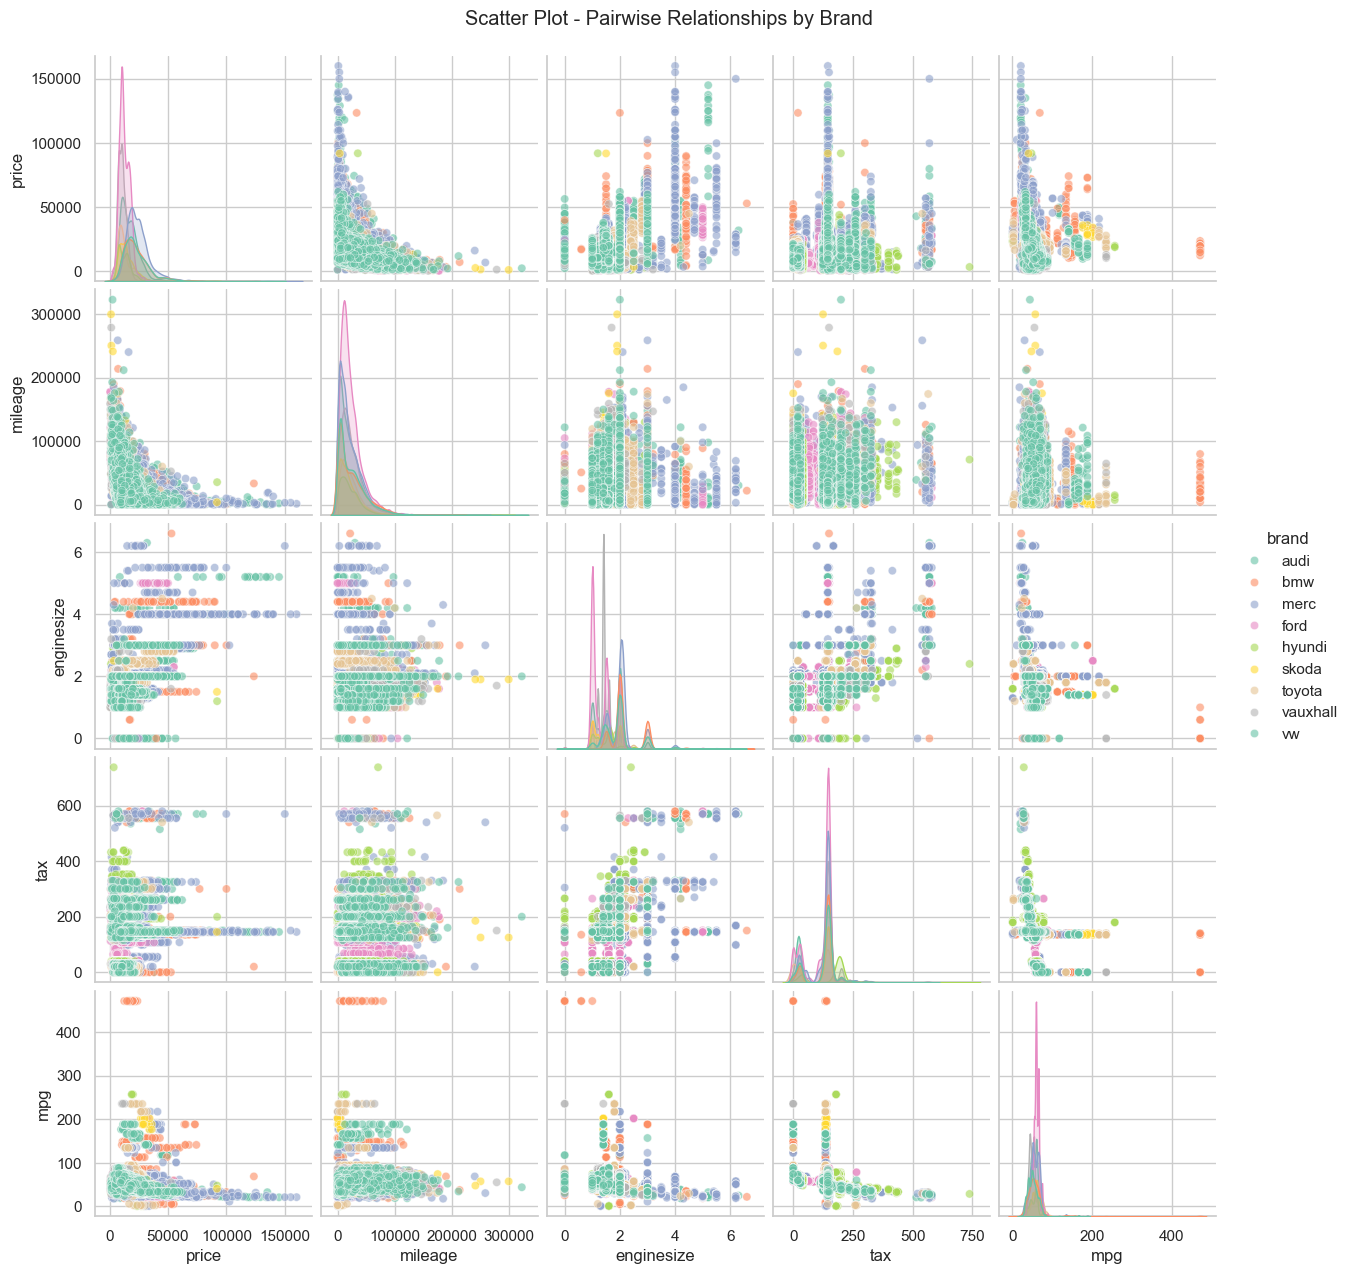

In [52]:
# Scatter Plot - Pairwise Relationships between Features

import seaborn as sns
import matplotlib.pyplot as plt

# Columns to plot (only numeric), and brand for hue
numeric_cols = ['price', 'mileage', 'enginesize', 'tax', 'mpg']
scatter_df = train_df[numeric_cols + ['brand']].dropna()

# Ensure 'brand' is a string (not categorical)
scatter_df['brand'] = scatter_df['brand'].astype(str)

# Pairplot
sns.pairplot(
    scatter_df,
    hue='brand',
    vars=numeric_cols,  # only numeric columns here
    palette='Set2',
    plot_kws={'alpha': 0.6}
)

plt.suptitle("Scatter Plot - Pairwise Relationships by Brand", y=1.02)
plt.savefig(os.path.join(plot_folder,"scatter_matrix.png"))
plt.show()




**Interpretation**
- By examining the Scatler plot combine with heatmap, I observe that price shows a clear positive linear correlation with both engine size and year, indicating that newer cars with larger engines tend to be priced higher. In contrast, mpg and mileage exhibit negative correlations with price, suggesting that higher fuel efficiency and more usage typically correspond to lower prices. Additionally, the data contains some outliers, notably where engine size = 0, which are likely data entry errors and should be handled during preprocessing.

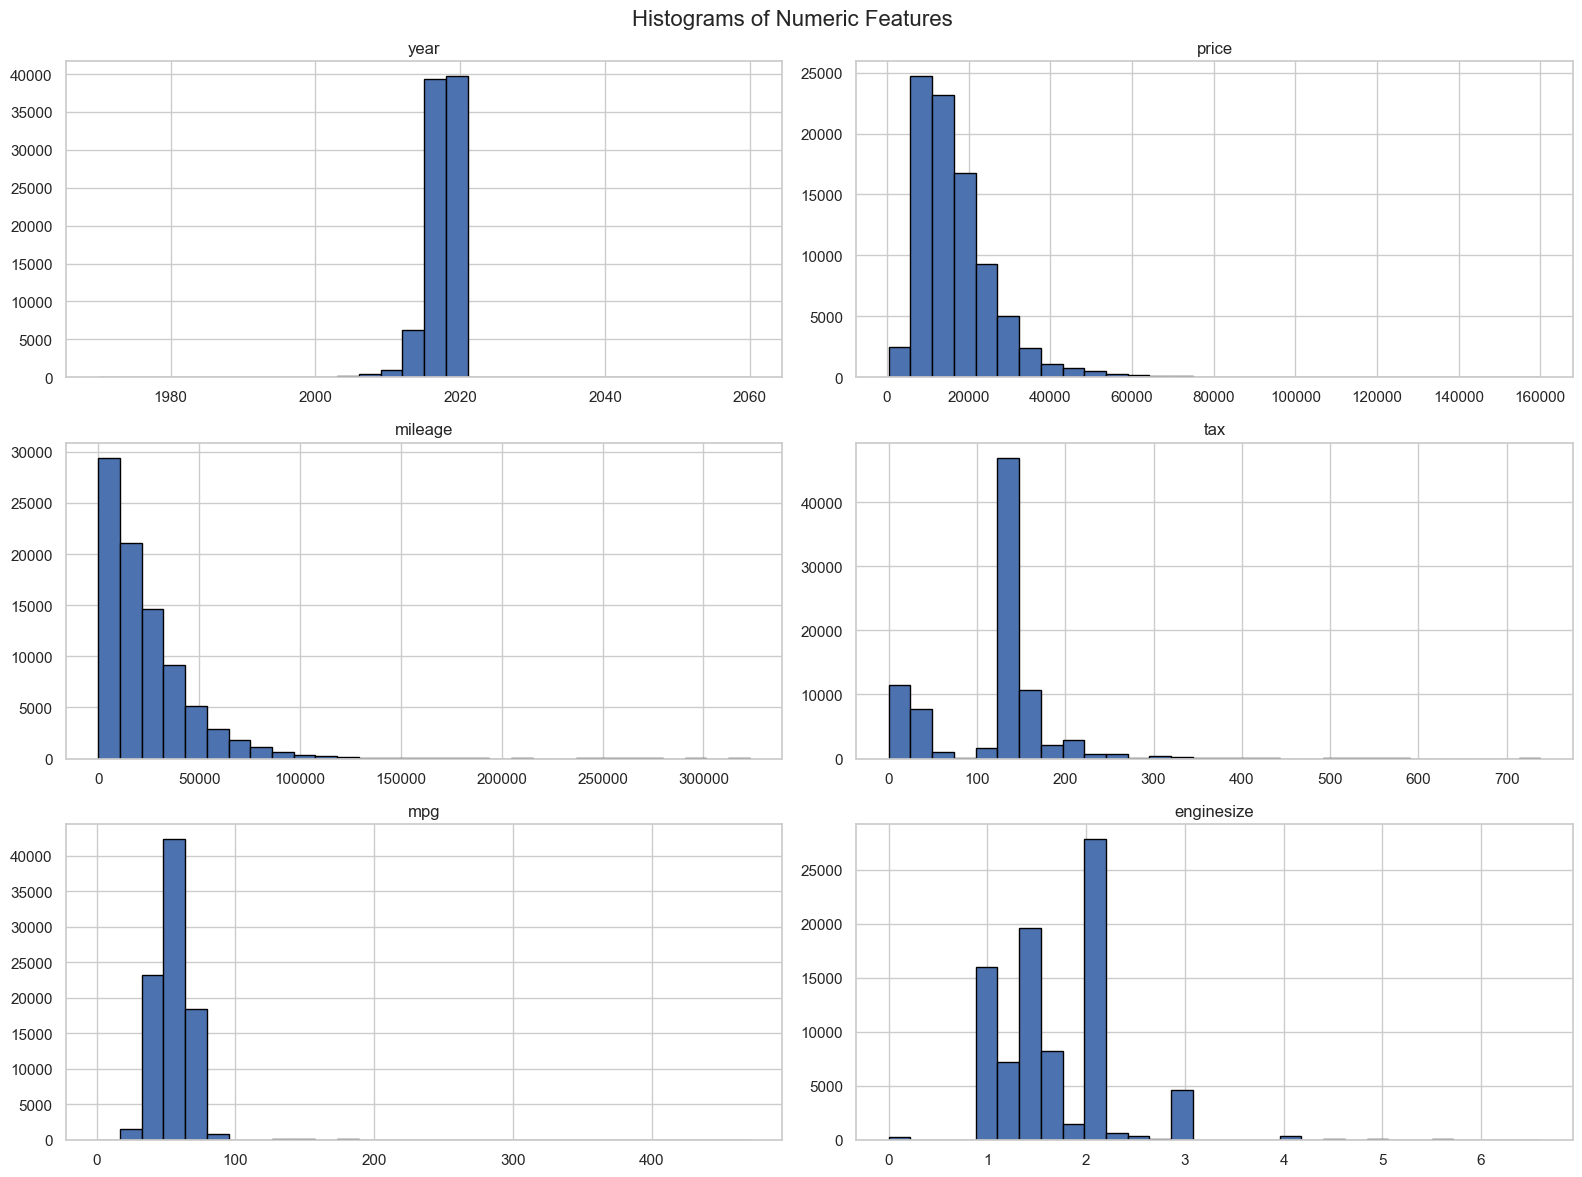

In [53]:
## Another view of Histogram

numeric_cols = train_df.select_dtypes(include=['number']).columns.tolist()

# Plot histograms for all numeric columns
train_df[numeric_cols].hist(bins=30, figsize=(16, 12), edgecolor='black')
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(plot_folder,"histograms_numeric_features.png"))
plt.show()



In [54]:
## I apply One-Way ANOVA (Analysis of Variance) to examine whether the mean car prices significantly differ across levels of key categorical variables

from scipy.stats import f_oneway

# ANOVA: Price ~ Transmission
df_trans = train_df[['transmission', 'price']].dropna()
grouped_trans = [group['price'].values for _, group in df_trans.groupby('transmission')]
f_stat_t, p_val_t = f_oneway(*grouped_trans)

print("ANOVA for Transmission:")
print("F-statistic:", f_stat_t)
print("p-value:", p_val_t)
print("Significant difference in means." if p_val_t < 0.05 else "No significant difference in means.")
print()

# ANOVA: Price ~ FuelType
df_fuel = train_df[['fueltype', 'price']].dropna()
grouped_fuel = [group['price'].values for _, group in df_fuel.groupby('fueltype')]
f_stat_f, p_val_f = f_oneway(*grouped_fuel)

print("ANOVA for FuelType:")
print("F-statistic:", f_stat_f)
print("p-value:", p_val_f)
print("Significant difference in means." if p_val_f < 0.05 else "No significant difference in means.")

# ANOVA: Price ~ Brand
df_fuel = train_df[['brand', 'price']].dropna()
grouped_fuel = [group['price'].values for _, group in df_fuel.groupby('brand')]
f_stat_f, p_val_f = f_oneway(*grouped_fuel)

print("ANOVA for Brand:")
print("F-statistic:", f_stat_f)
print("p-value:", p_val_f)
print("Significant difference in means." if p_val_f < 0.05 else "No significant difference in means.")


ANOVA for Transmission:
F-statistic: 12815.637960979242
p-value: 0.0
Significant difference in means.

ANOVA for FuelType:
F-statistic: 1052.576826124495
p-value: 0.0
Significant difference in means.
ANOVA for Brand:
F-statistic: 4399.975586888995
p-value: 0.0
Significant difference in means.


**Interpretation:** 

In all three cases — brand, transmission, and fuel type — the ANOVA results show statistically significant differences in mean car prices across categories, supporting the idea that these features are important predictors of price and should be included in the modeling process.

## 5. Model Training & Evaluation

In this analysis, I compare the performance of three regression models—Linear Regression, Ridge Regression, and Lasso Regression—on a cleaned dataset of car prices. I start by:

1. Cleaning the data: Removing rows with missing values.

2. Encoding categorical variables: Using one-hot encoding to prepare the data for modeling.

3. Defining models: Including baseline linear, Ridge (L2 regularization), and Lasso (L1 regularization).

4. Evaluating performance: Applying 5-fold cross-validation to assess each model's R² and RMSE across folds.

5. Summarizing results:

    -   Calculated average R² and RMSE for each model.

    -   Visualized the results using bar plots.

    -   Printed detailed per-fold evaluation metrics for transparency.

In [55]:
# Step 1,2

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error


# One-hot encode categorical variables
df_encoded = pd.get_dummies(train_df, columns=['brand', 'fueltype', 'model', 'transmission'], drop_first=True)

# Split features and target
X = df_encoded.drop(columns=['price'])
y = df_encoded['price']

train_df_clean = train_df.dropna()

X = train_df_clean.drop(columns=['price'])
y = train_df_clean['price']

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)


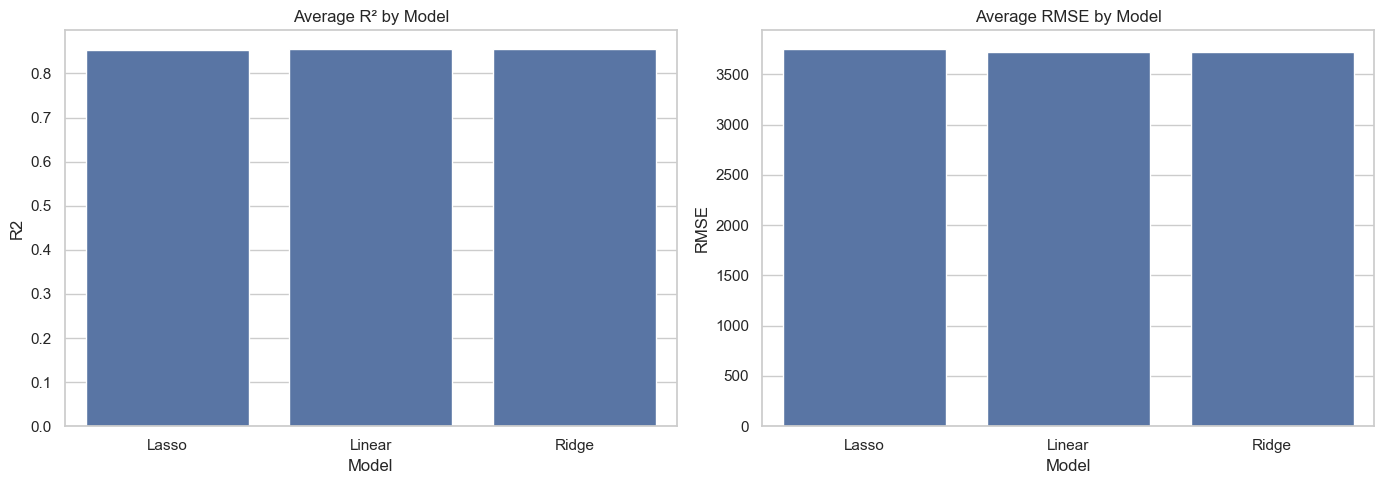

     Model  Fold        R2         RMSE
10   Lasso     1  0.852025  3745.492632
11   Lasso     2  0.855626  3742.004454
12   Lasso     3  0.850802  3736.991529
13   Lasso     4  0.857377  3672.254995
14   Lasso     5  0.848191  3847.478500
0   Linear     1  0.853224  3730.287402
1   Linear     2  0.859754  3688.128598
2   Linear     3  0.852344  3717.627855
3   Linear     4  0.859714  3642.046317
4   Linear     5  0.850438  3818.904041
5    Ridge     1  0.853525  3726.464135
6    Ridge     2  0.859524  3691.146715
7    Ridge     3  0.852544  3715.111327
8    Ridge     4  0.859728  3641.864646
9    Ridge     5  0.850228  3821.576249


In [56]:
# Step 3,4 5

# Model
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1.0, max_iter=10000)
}

# K-Fold Cross-Validation 
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    for fold, (train_index, test_index) in enumerate(kf.split(X_encoded), 1):
        X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results.append({
            'Model': name,
            'Fold': fold,
            'R2': r2,
            'RMSE': rmse
        })

# Convert to DataFrame 
results_df = pd.DataFrame(results)

# Visualize Average Metrics
avg_results = results_df.groupby('Model')[['R2', 'RMSE']].mean().reset_index()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=avg_results, x='Model', y='R2')
plt.title("Average R² by Model")

plt.subplot(1, 2, 2)
sns.barplot(data=avg_results, x='Model', y='RMSE')
plt.title("Average RMSE by Model")

plt.tight_layout()
plt.show()

# Show All Fold Results
results_df = results_df.reset_index(drop=True)
print(results_df.sort_values(by=['Model', 'Fold']))


**Justification**

- All three models perform similarly well, with R² around 0.85–0.86, which is quite good for real-world price prediction.

- Linear and Ridge consistently outperform Lasso slightly, suggesting:
    - Lasso's feature selection may be dropping some useful predictors
    - Regularization (Ridge) doesn't drastically improve over basic Linear, indicating the predictors are already well-behaved

So, if I have to choose, I will choose **Ridge** for a bit more robustness, also it can anticipate overfitting and colinearity in future.

**Next Step: Add XGBoost**

- To further improve performance and compare against linear models, I plan to add XGBoost to the evaluation. XGBoost is a powerful gradient boosting framework known for:

    -   Handling non-linear relationships,

    -   Automatically managing missing values,

    -   Often outperforming linear models on structured/tabular data.

In [57]:
# XGBoost Model
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error


train_df.drop(columns=['car_fullname'], inplace=True, errors='ignore')

X = train_df.drop(columns=['price'])
y = train_df['price']

# One-hot encode string columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Then train-test split
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Model initilization

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,          # allow more rounds
    max_depth=6,
    learning_rate=0.05,         # smaller learning rate improves generalization
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model with early stoppping

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=20,   #  stops if no improvement for 20 rounds
    verbose=True
)

# predit and print result

y_pred = xgb_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"R²: {r2:.4f}, RMSE: {rmse:.2f}")


c:\Anaconda\envs\car-prediction\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:18490.90454
[1]	validation_0-rmse:17618.15665
[2]	validation_0-rmse:16802.08878
[3]	validation_0-rmse:16008.44477
[4]	validation_0-rmse:15259.59013
[5]	validation_0-rmse:14570.01436
[6]	validation_0-rmse:13891.97312
[7]	validation_0-rmse:13249.47054
[8]	validation_0-rmse:12639.46772
[9]	validation_0-rmse:12089.62539
[10]	validation_0-rmse:11542.64495
[11]	validation_0-rmse:11026.30321
[12]	validation_0-rmse:10537.06706
[13]	validation_0-rmse:10070.82700
[14]	validation_0-rmse:9629.70250
[15]	validation_0-rmse:9211.01649
[16]	validation_0-rmse:8826.43863
[17]	validation_0-rmse:8449.73190
[18]	validation_0-rmse:8098.24246
[19]	validation_0-rmse:7762.18657
[20]	validation_0-rmse:7446.84469
[21]	validation_0-rmse:7158.57798
[22]	validation_0-rmse:6878.03225
[23]	validation_0-rmse:6611.31042
[24]	validation_0-rmse:6364.10401
[25]	validation_0-rmse:6130.27030
[26]	validation_0-rmse:5908.81867
[27]	validation_0-rmse:5716.52304
[28]	validation_0-rmse:5518.38080
[29]	valid

**Interpretation**

- R² = 0.9620 → XGBoost explains 96.2% of the variance in car prices — a huge improvement over linear models.

- RMSE = 1897.94 → On average, XGBoost predictions are off by ~$1,900, compared to ~$3,700 from Ridge/Linear.

- I choose XGBoost as your final model. I might captures:
    - Non-linear relationships
    - Feature interactions
    - Handles high-cardinality and on-hot encoded data efficiently.

**Next Step: Apply log transformation**

- Since the range of price is large and likely right-skewed, so I want to apply log transformation of price. This help stabilize variance and reduce impact of extreme value . I check with XGBoost one more time to see any improvement



In [58]:
# Apply log transformation to the target variable

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error


train_df.drop(columns=['car_fullname'], inplace=True, errors='ignore')

X = train_df.drop(columns=['price'])
y = train_df['price']

# One-hot encode string columns
X_encoded = pd.get_dummies(X, drop_first=True)
y_log = np.log1p(y) 

# Then train-test split
X_train, X_val, y_train_log, y_val_log = train_test_split(X_encoded, y_log, test_size=0.2, random_state=42)

# Model initilization

xgb_model1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

# Train the model with early stoppping

xgb_model1.fit(
    X_train, y_train_log,
    eval_set=[(X_val, y_val_log)],
    eval_metric="rmse",
    early_stopping_rounds=50, 
    verbose=True
)

# predit and print result

y_pred_log = xgb_model1.predict(X_val)
y_pred = np.expm1(y_pred_log)  # reverse log1p

# Evaluate using original price
y_val = np.expm1(y_val_log)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Improved XGBoost R²: {r2:.4f}, RMSE: {rmse:.2f}")


c:\Anaconda\envs\car-prediction\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Anaconda\envs\car-prediction\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:9.01112
[1]	validation_0-rmse:8.92110
[2]	validation_0-rmse:8.83201
[3]	validation_0-rmse:8.74378
[4]	validation_0-rmse:8.65644
[5]	validation_0-rmse:8.56999
[6]	validation_0-rmse:8.48438
[7]	validation_0-rmse:8.39964
[8]	validation_0-rmse:8.31575
[9]	validation_0-rmse:8.23272
[10]	validation_0-rmse:8.15049
[11]	validation_0-rmse:8.06908
[12]	validation_0-rmse:7.98848
[13]	validation_0-rmse:7.90869
[14]	validation_0-rmse:7.82969
[15]	validation_0-rmse:7.75149
[16]	validation_0-rmse:7.67410
[17]	validation_0-rmse:7.59746
[18]	validation_0-rmse:7.52158
[19]	validation_0-rmse:7.44646
[20]	validation_0-rmse:7.37209
[21]	validation_0-rmse:7.29850
[22]	validation_0-rmse:7.22560
[23]	validation_0-rmse:7.15344
[24]	validation_0-rmse:7.08200
[25]	validation_0-rmse:7.01127
[26]	validation_0-rmse:6.94126
[27]	validation_0-rmse:6.87197
[28]	validation_0-rmse:6.80333
[29]	validation_0-rmse:6.73540
[30]	validation_0-rmse:6.66814
[31]	validation_0-rmse:6.60158
[32]	validation_0-

## 6. Model Comparison & Selection

**Final Model Selection Justification**

After evaluating both log-transformed and non-log-transformed versions of the XGBoost model, the non-log model achieved a lower RMSE of 1897.94, compared to 2348.86 from the log-transformed model. This indicates that the non-log model's predictions are, on average, about $450 closer to the actual car prices.

**Therefore, I select the non-log XGBoost model as the final model for car price prediction.**

In [59]:
# saving non-log xgboost model
import joblib
X_encoded = pd.get_dummies(X, drop_first=True)
X_columns = X_encoded.columns

# Ensure the folder exists
model_folder = "Models_Folder"
os.makedirs(model_folder, exist_ok=True)

joblib.dump(X_columns, os.path.join(model_folder,"xgboost_model_columns.pkl"))
joblib.dump(xgb_model, os.path.join(model_folder,'xgboost_model.pkl'))


['Models_Folder\\xgboost_model.pkl']

## 7. Predict Test Data & Saving Results

In [60]:
## Predict test data

# Ensure the folder exists
result_folder = "Results_Folder"
os.makedirs(result_folder, exist_ok=True)

# Load test_features.csv
test_path = "test_features/test_features.csv"
test_df = pd.read_csv(test_path)

# Load the trained model, columns
X_columns = joblib.load(os.path.join(model_folder,"xgboost_model_columns.pkl"))
loaded_model = joblib.load(os.path.join(model_folder,'xgboost_model.pkl'))

# One-hot encode test_df
X_test = pd.get_dummies(test_df, columns=['brand', 'fuelType', 'model', 'transmission'], drop_first=True)

# Align columns with training data (fill missing columns with 0)
X_test = X_test.reindex(columns=X_columns, fill_value=0)

# Predict using the loaded model
predictions = loaded_model.predict(X_test)

# Add prediction to test_df
test_df['predict_price'] = predictions

# Save to submission.csv (assuming 'id' is test_df.index or a column)
submission_df = test_df[['predict_price']].copy()
submission_df['id'] = test_df.index  # adjust if 'id' is an actual column
submission_df.to_csv(os.path.join(result_folder,"submission.csv"), index=False)


# Overwrite the original file with new column
test_df.to_csv(os.path.join(result_folder,"test_features_with_prediction.csv"), index=False)

print("Predictions added to test_df and saved to 'submission.csv' and 'test_features_with_prediction.csv'")



Predictions added to test_df and saved to 'submission.csv' and 'test_features_with_prediction.csv'


In [61]:
## Checking RMSE on training data using XGBoost model to predict price

train_df = pd.read_csv(os.path.join(output_folder,"train_data.csv"))

# Load the trained model, columns
X_columns = joblib.load(os.path.join(model_folder,"xgboost_model_columns.pkl"))
loaded_model = joblib.load(os.path.join(model_folder,'xgboost_model.pkl'))

if 'price' in train_df.columns:
    y_true = train_df['price']
    X = train_df.drop(columns=['price'])
else:
    X = train_df.copy()

X_encoded = pd.get_dummies(X, columns=['brand', 'fueltype', 'model', 'transmission'], drop_first=True)
X_encoded = X_encoded.reindex(columns=X_columns, fill_value=0)
predictions = loaded_model.predict(X_encoded)

train_df['predict_price'] = predictions
train_df.to_csv(os.path.join(result_folder,"train_with_predictions.csv"), index=False)

print("Predictions on training data saved to 'train_with_predictions.csv'")

rmse = np.sqrt(mean_squared_error(train_df['price'], train_df['predict_price']))
print(f"RMSE on train_df: {rmse:.2f}")


Predictions on training data saved to 'train_with_predictions.csv'
RMSE on train_df: 1744.50


- Prediction results are saved in multiple files within the Results_Folder:

    - **test_features_with_prediction.csv**: Contains the original test features along with a new column predict_price.

    - **submission.csv**: Includes only the predicted prices, aligned with the test data index, ready for submission.

- Additionally, predictions are also made on the training dataset(**train_with_predictions.csv**). A new column predict_price is added to compare predicted prices with actual prices, which allows for manual RMSE calculation and evaluation of the model's accuracy on known data.

## 8. Model Performance Assessment

The machine learning model developed for predicting car prices demonstrates a solid performance, having been trained and evaluated using a comprehensive set of vehicle attributes such as brand, model, engine size, transmission, and mileage. With careful preprocessing and the application of models like Linear Regression, Ridge, Lasso, and XGBoost, the approach captures key relationships in the data. However, the model's predictive performance could still benefit from additional enhancements. For instance, improving feature engineering by adding interaction terms or log-transforming skewed variables may help capture nonlinear patterns. Furthermore, tuning hyperparameters more extensively through randomized or Bayesian search techniques could yield further gains. Finally, incorporating external datasets, such as macroeconomic indicators or regional pricing data could help the model generalize better across diverse market conditions.
